# Tarea 2
Autores:
- Hernán Francisco Díaz Farías
- María Angélica Parra Mendoza
- Loreto Constanza Zavala Gaete


Utilizaremos los datos que nos ha entregado una vidriería, la cual necesita que en base a la composición (química) de los vidros, determinemos cual de ellos podría venir defectuoso de fábrica. Para esto contamos con registro de 214 vidrios, para los cuales cada uno de ellos se nos entrega mediciones de cantidades de Sodio, Magnesio, Aluminio, Silicio, Potacio, Calcio, Bario y Hierro, además de un valor de tipo de vidrio.

## 1.Hacer una exploración de los datos y decidir qué modelo va a utilizar. Fundamentar su elección.
### 1.1 Cargar los datos

In [41]:
import pandas as pd
import diptest
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

In [42]:
df = (
    pd.read_excel('../data/Clase 2 - Glass.xlsx')
    .drop(columns=['Unnamed: 0'])
)
df.head()

,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass,outlier
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,0


In [43]:
df.isnull().sum()

Na               0
Mg               0
Al               0
Si               0
K                0
Ca               0
Ba               0
Fe               0
Type_of_glass    0
outlier          0
dtype: int64

### 1.2 Visualización de histogramas.

De acuerdo a la descripción de las ventajas del modelo [**Isolation Forest**](https://cran.r-project.org/web/packages/isotree/vignettes/An_Introduction_to_Isolation_Forests.html), se menciona que:
- Es robusto a la presencia de valores atípicos en los datos de entrenamiento.
- Es robusto a distribuciones multimodal.
- Insensible a la escala de los datos.
- Veloz para entrenar y predecir.
- No varía a la metrica de distancia a utilizar.

Para escoger el modelo, se realizará un análisis de los histogramas de las variables para determinar si son unimodales o multimodales. Si las variables son multimodales, se utilizará el modelo **Isolation Forest**.

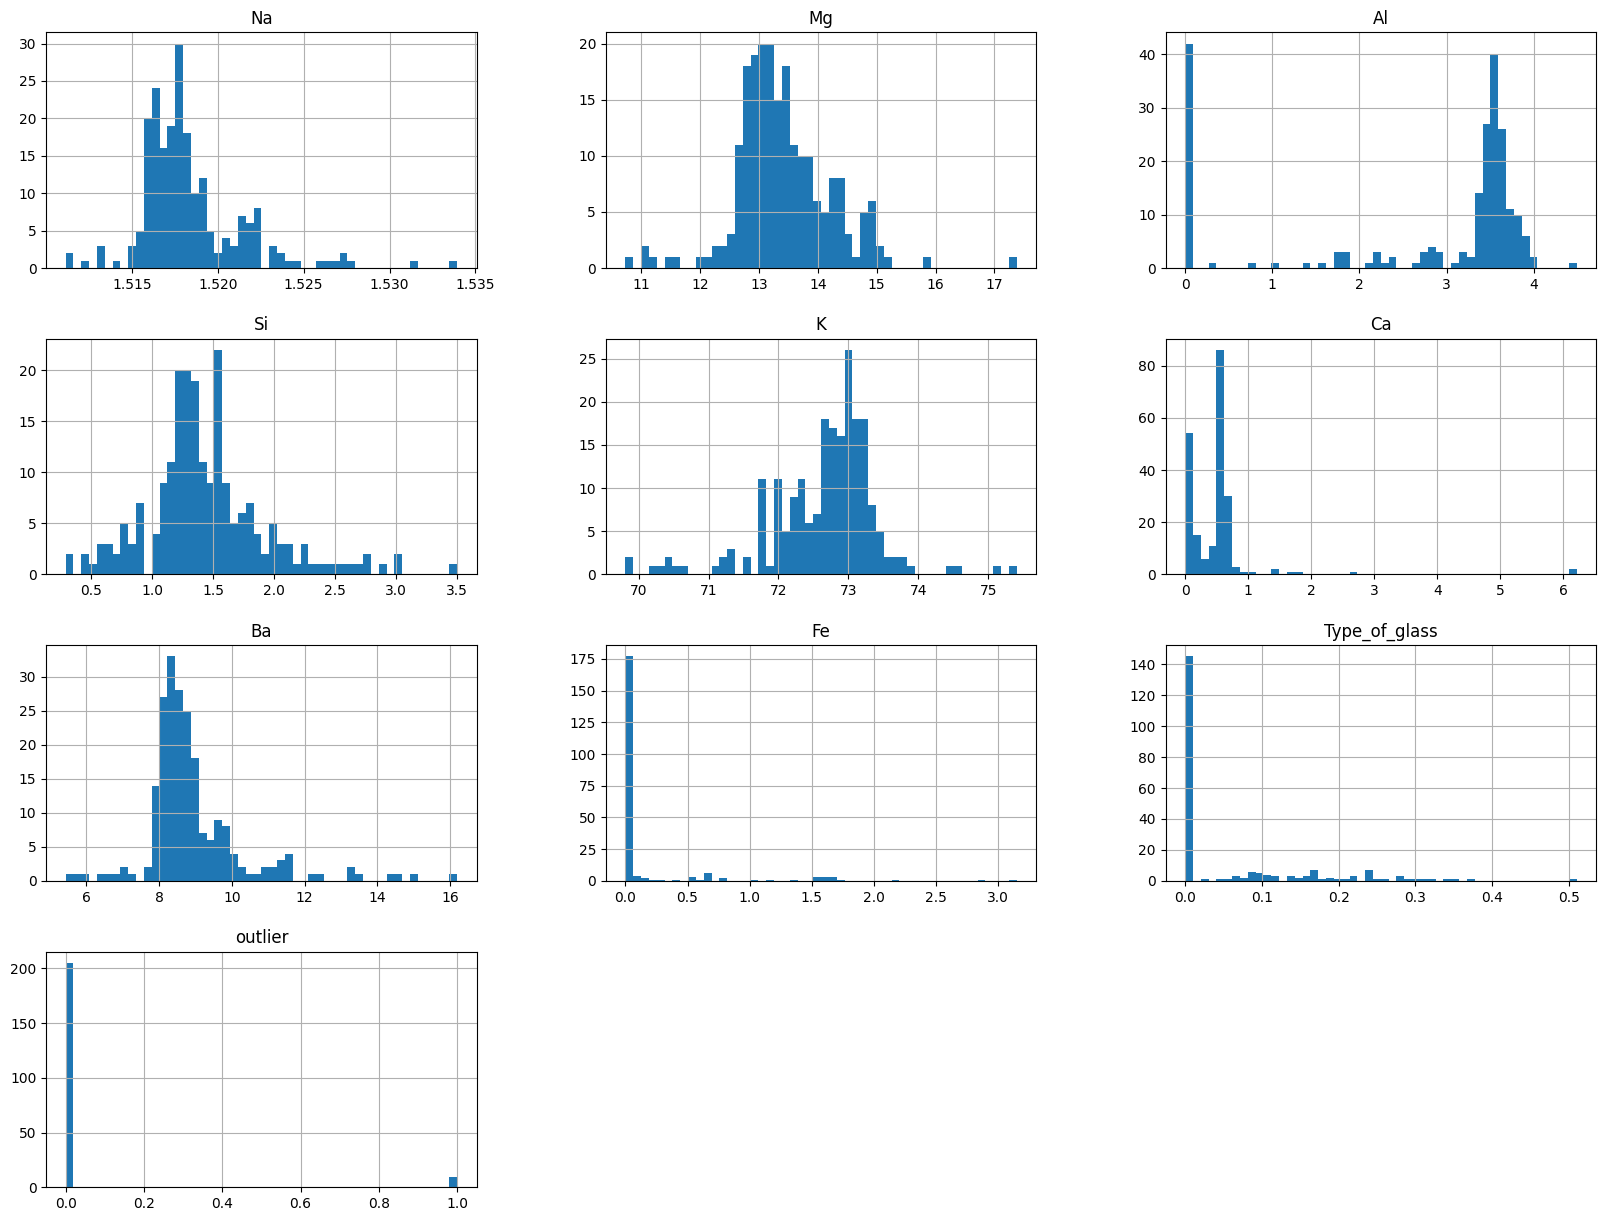

In [44]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

### 1.3 Test de multimodalidad

In [45]:
for col in df.columns:
    # test dip
    dip, pval = diptest.diptest(df[col])
    if pval < 0.05:
        print(f'La variable {col} es probablemente multimodal: {dip}, {pval}')
    else:
        print(f'La variable {col} es probablemente unimodal: {dip}, {pval}')

La variable Na es probablemente unimodal: 0.027824978759555138, 0.29678227340828256
La variable Mg es probablemente unimodal: 0.02397641299510457, 0.5598736607065488
La variable Al es probablemente multimodal: 0.09813084112149532, 0.0
La variable Si es probablemente unimodal: 0.02266355140186915, 0.6621823323183281
La variable K es probablemente unimodal: 0.019910605444939947, 0.8545579937565113
La variable Ca es probablemente multimodal: 0.07971412864211103, 0.0
La variable Ba es probablemente unimodal: 0.020478284771852703, 0.8206700523552444
La variable Fe es probablemente unimodal: 0.017964693665628247, 0.9483906034584101
La variable Type_of_glass es probablemente unimodal: 0.031061022539857062, 0.15922944239922954
La variable outlier es probablemente unimodal: 0.02102803738317757, 0.7850035090854165


De acuerdo a los histogramas y el test de multimodalidad, se observa que existen variables que son unimodales y otras que son multimodales. Por lo tanto, se utilizará el modelo **Isolation Forest** para detectar los vidrios defectuosos de fábrica.

## 2. En base a su elección anterior, procese sus datos para dejarlos como input para el modelo.
### 2.1 Normalización de los datos
A pesar de que el modelo **Isolation Forest** es insensible a la escala de los datos, se normalizarán los datos para que el modelo pueda aprender de manera más eficiente. Se utilizará el método **RobustScaler** para normalizar los datos, debido a que es robusto a la presencia de valores atípicos.

In [46]:
scaler = RobustScaler()
y = df['outlier']
X = df.drop(columns=['outlier'])
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.describe()

,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_of_glass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,0.260122,0.117548,-0.535668,0.192969,-0.172217,-0.118859,0.382802,0.175047,0.570093
std,1.152510,0.890031,0.971318,1.134704,0.959190,1.337829,1.526170,0.497219,0.974387
min,-2.478178,-2.801090,-2.343434,-2.431818,-3.690402,-1.138462,-3.399464,0.000000,0.000000
25%,-0.439279,-0.427793,-0.919192,-0.386364,-0.631579,-0.887179,-0.386059,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.560721,0.572207,0.080808,0.613636,0.368421,0.112821,0.613941,0.000000,1.000000
max,6.166983,4.446866,0.680135,4.863636,3.244582,11.600000,8.139410,3.150000,5.100000


## 3. Ocupe el modelo escogido y exponga las principales características que tienen los datos encontrados como anómalos.

In [47]:
IsoFor_model = IsolationForest(
    n_estimators = 500, #Numero de árboles considerados
    max_samples = 'auto', #Numero de observaciones para entrenar
    n_jobs=-1,
    contamination = 0.2, #Porcentaje de anomalías esperada
    random_state = 2023 #Semilla para reproducibilidad
)
IsoFor_model.fit(X_scaled)
anomaly_score = IsoFor_model.score_samples(X_scaled)
anomaly_classification = IsoFor_model.predict(X_scaled)
print(anomaly_classification == 1)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False False False
 False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False  T

In [48]:
# comparamos con y
resultado = pd.DataFrame({'y': y, 'anomaly_classification': anomaly_classification})

In [56]:
TP = resultado[(resultado['y'] == 1) & (resultado['anomaly_classification'] == -1)].shape[0]
TN = resultado[(resultado['y'] == 0) & (resultado['anomaly_classification'] == 1)].shape[0]
FP = resultado[(resultado['y'] == 0) & (resultado['anomaly_classification'] == -1)].shape[0]
FN = resultado[(resultado['y'] == 1) & (resultado['anomaly_classification'] == 1)].shape[0]
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}')

Accuracy: 0.7850467289719626, Precision: 0.06976744186046512, Recall: 0.3333333333333333, F1: 0.11538461538461539


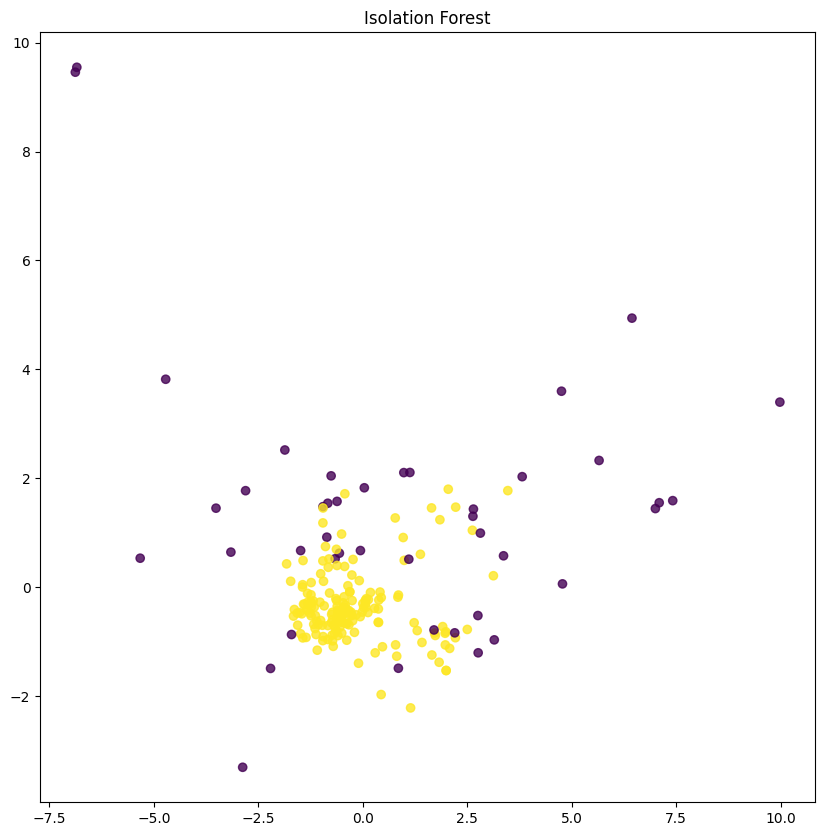

In [24]:
# Graficar la región de decisión
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_classification, alpha=0.8)
plt.title('Isolation Forest')
plt.show()
